<a href="https://colab.research.google.com/github/Usama-zia/split_decision_analytics/blob/main/SplitTest_Marketeer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective

This notebook aims to analyze the effectiveness of an ad campaign compared to a public service announcement (PSA) approach in driving conversions. The analysis focuses on identifying key factors that influence conversion rates and providing actionable insights for optimizing ad campaigns to maximize return on investment.


# Imports and dataset Loading

In [6]:
# Load Packages
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import statsmodels.api as sm
import scipy.stats as stats

import time
import warnings
warnings.filterwarnings('ignore')

#preprocessing
from sklearn.preprocessing import OrdinalEncoder

# statistical Packages
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.stats.contingency_tables import mcnemar
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact
from scipy.stats import pearsonr
from scipy.stats import t
from scipy.stats import kstest
from scipy.stats import levene
from scipy.stats import bartlett
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal

In [7]:
# Visualization Management

#color_pal = sns.color_palette()
#color_pal_extra = plt.rcParams["axes.prop_cycle"].by_key()["color"]
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pacoty.mplstyle')
#plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
pd.set_option('display.max_columns', 500)

In [3]:
#clone dataset from github repository
!git init
!git remote add origin https://github.com/Usama-zia/split_decision_analytics.git
!git config core.sparseCheckout true
!echo "data/" >> .git/info/sparse-checkout
!git pull origin main > /dev/null

Reinitialized existing Git repository in /content/.git/
error: remote origin already exists.
From https://github.com/Usama-zia/split_decision_analytics
 * branch            main       -> FETCH_HEAD


In [4]:
#unzip dataset
!unzip /content/data/marketing-ab-testing.zip -d data

Archive:  /content/data/marketing-ab-testing.zip
  inflating: data/marketing_AB.csv   


In [8]:
df = pd.read_csv('/content/data/marketing_AB.csv')

# Dataset Overview

Column Name | Description
--- | ---
Index | Row index
user id | User ID (unique)
test_group | If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement
converted | If a person bought the product then True, else is False
total_ads | Amount of ads seen by person
most_ads_day | Day that the person saw the biggest amount of ads
most_ads_hour | Hour of day that the person saw the biggest amount of ads

# Data Understanding and Cleaning

In [9]:
#(588101, 7)
# No of rows and columns of dataset
df.shape

(588101, 7)

In [10]:
df.head(10)

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14
5,5,1137664,ad,False,734,Saturday,10
6,6,1116205,ad,False,264,Wednesday,13
7,7,1496843,ad,False,17,Sunday,18
8,8,1448851,ad,False,21,Tuesday,19
9,9,1446284,ad,False,142,Monday,14


In [ ]:
#Clean colmun names
def clean_col_names(col_name):
  return re.sub(r"\s+", "_", col_name.strip())

df.rename(columns=clean_col_names, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed:_0     588101 non-null  int64 
 1   user_id        588101 non-null  int64 
 2   test_group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total_ads      588101 non-null  int64 
 5   most_ads_day   588101 non-null  object
 6   most_ads_hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


In [ ]:
#check any values are null
df.isnull().any()

Unnamed:_0       False
user_id          False
test_group       False
converted        False
total_ads        False
most_ads_day     False
most_ads_hour    False
dtype: bool

In [ ]:
#check how many values are null
#df.isnull().sum()

In [ ]:
# view details of numerical columns
df.describe()

,Unnamed:_0,user_id,total_ads,most_ads_hour
count,588101.000000,5.881010e+05,588101.000000,588101.000000
mean,294050.000000,1.310692e+06,24.820876,14.469061
std,169770.279668,2.022260e+05,43.715181,4.834634
min,0.000000,9.000000e+05,1.000000,0.000000
25%,147025.000000,1.143190e+06,4.000000,11.000000
50%,294050.000000,1.313725e+06,13.000000,14.000000
75%,441075.000000,1.484088e+06,27.000000,18.000000
max,588100.000000,1.654483e+06,2065.000000,23.000000


In [ ]:
# view details of categorical columns
df.describe(include = 'object')

,test_group,most_ads_day
count,588101,588101
unique,2,7
top,ad,Friday
freq,564577,92608


In [ ]:
#checking for duplicate values
df.duplicated(subset = 'user_id').sum()

0

## Analysis



*   There are no null values in any column.
*   There are no duplicate rows.
*   column "Unamed:_0" is the same as index column and "user_id" column is not needed for A/B testing. So they both will be droped.



In [ ]:
# drop 'Unnamed:_0' and 'user_id' columns.
df.drop(['Unnamed:_0', 'user_id'], axis = 1, inplace = True)

In [ ]:
df.head(5)

,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,ad,False,130,Monday,20
1,ad,False,93,Tuesday,22
2,ad,False,21,Tuesday,18
3,ad,False,355,Tuesday,10
4,ad,False,276,Friday,14


In [ ]:
#checking No of unique values in each column
print(f'Unique values in each column:\n{df.nunique()}')

Unique values in each column:
test_group         2
converted          2
total_ads        807
most_ads_day       7
most_ads_hour     24
dtype: int64


##Outlier detection


In [ ]:
def remove_outliers_iqr(df, columns):
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((df[columns] < (Q1 - 1.5 * IQR)) | (df[columns] > (Q3 + 1.5 * IQR))).any(axis=1)
    return df[mask]

# Specify columns we want to check for outliers
columns_to_check = ['total_ads']  # Replace with relevant column names
df_cleaned_iqr = remove_outliers_iqr(df, columns_to_check)

print("Original DataFrame shape:", df.shape)
print("Cleaned DataFrame shape (IQR):", df_cleaned_iqr.shape)
df = df_cleaned_iqr

Original DataFrame shape: (588101, 5)
Cleaned DataFrame shape (IQR): (536044, 5)


In [ ]:
df.columns

Index(['test_group', 'converted', 'total_ads', 'most_ads_day',
       'most_ads_hour'],
      dtype='object')

In [ ]:
#check any values are null
df.isnull().any()

test_group       False
converted        False
total_ads        False
most_ads_day     False
most_ads_hour    False
dtype: bool

In [ ]:
#Checking number of unique values per columns
df.nunique()

test_group        2
converted         2
total_ads        61
most_ads_day      7
most_ads_hour    24
dtype: int64

# Exploratory Data Analysis

In [ ]:
#checking what unique values are in every columns
for column in df.columns:
  print(column.upper(), ":" , df[column].unique())

TEST_GROUP : ['ad' 'psa']
CONVERTED : [False  True]
TOTAL_ADS : [21 17 47 61 40 20  9 26 46  3 24 49 27 45 31 56 14 13 37 19 18 60 22 41
 57 28 53 43 33  7  6 34 32 44 39 30 59 10 16 36  1  5 52 15 29  8 50 35
  2 38 23  4 58 48 54 11 25 55 42 51 12]
MOST_ADS_DAY : ['Tuesday' 'Sunday' 'Wednesday' 'Friday' 'Saturday' 'Thursday' 'Monday']
MOST_ADS_HOUR : [18 19 13 20 11 21 16  8 12 10 23  6  1 22 17  9  0 14  7 15  2  3  4  5]


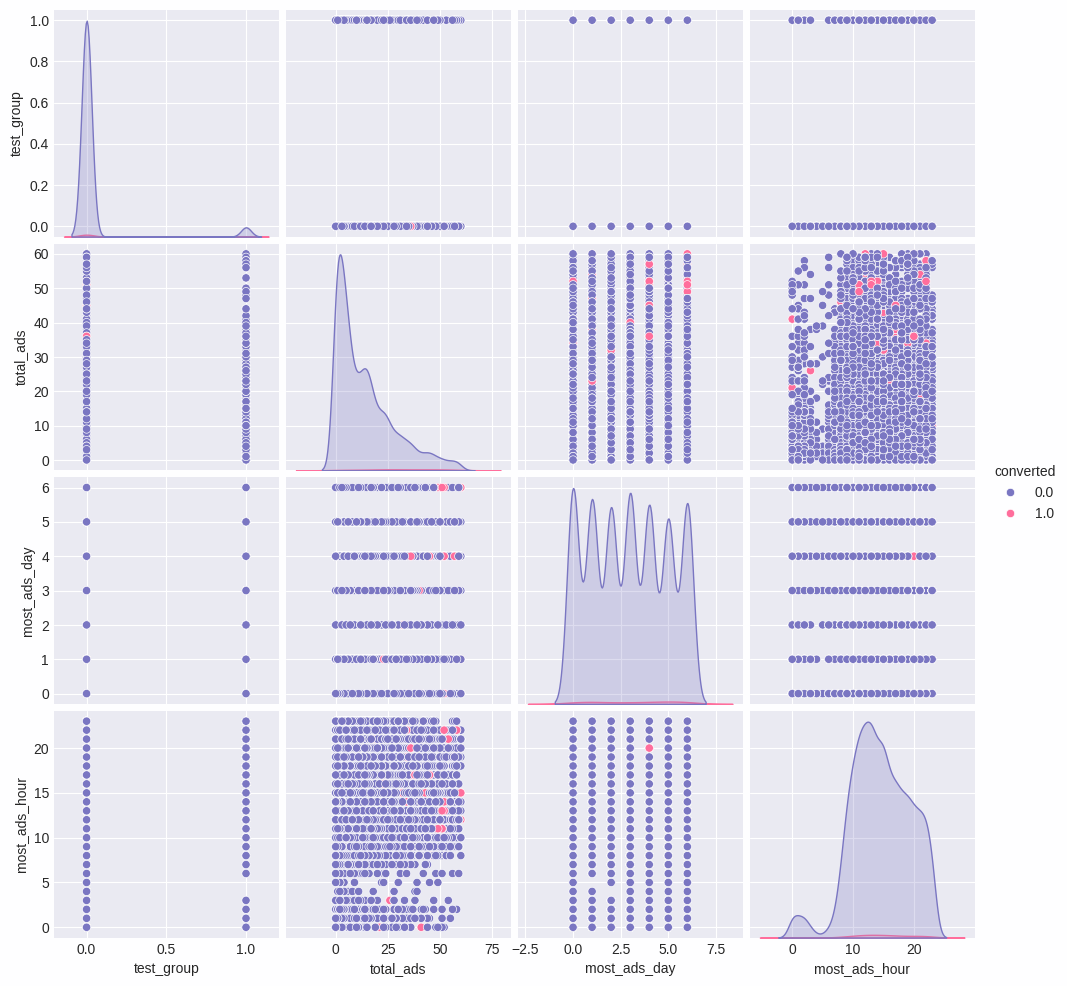

In [ ]:
df_pair_plot = df.copy()
df_pair_plot = df_pair_plot.sample(n=10000)

encoder = OrdinalEncoder()
df_pair_plot_encoded = encoder.fit_transform(df_pair_plot)

dddf3 = pd.DataFrame(df_pair_plot_encoded, columns=df_pair_plot.columns)

sns.pairplot(dddf3,
             vars = ['test_group', 'total_ads', 'most_ads_day', 'most_ads_hour'], # Use the numerical version
             hue='converted')
plt.show()

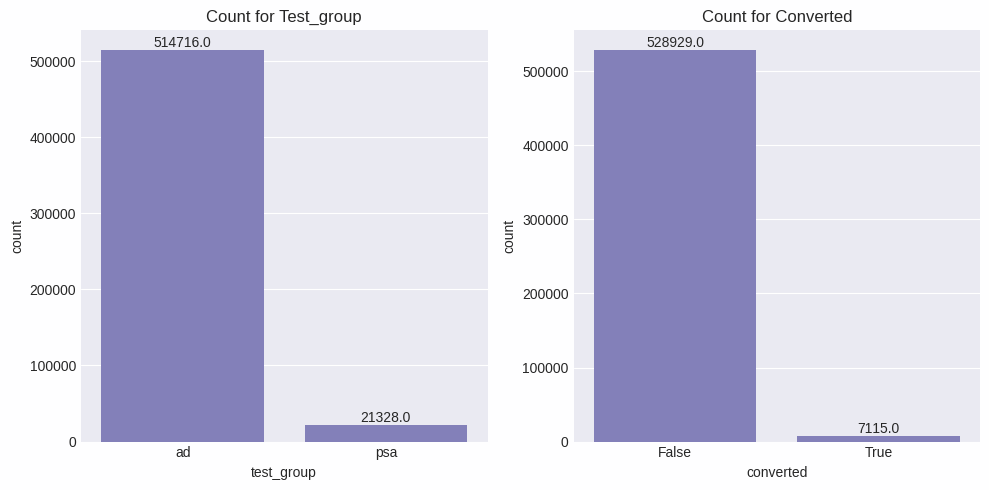

In [ ]:
# Bar plot for each test_group and number of converted
columns_to_plot = ['test_group', 'converted']

fig, ax = plt.subplots(1, len(columns_to_plot), figsize=(10, 5), dpi=100)
for i, col in enumerate(columns_to_plot):
    sns.countplot(data=df, x=col, ax=ax[i])
    ax[i].set_title(f'Count for {col.capitalize()}')
    for p in ax[i].patches:
        ax[i].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.tight_layout()

plt.show()

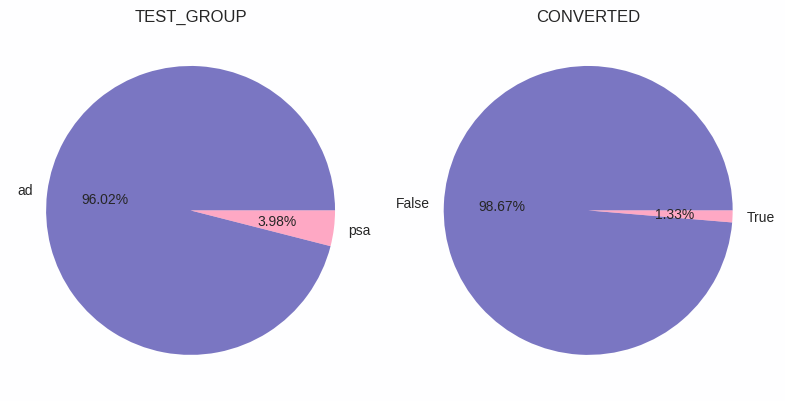

In [ ]:
# Pie chart for each test_group and percentage of converted
columns_to_plot = ['test_group', 'converted']
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.pie(df[columns_to_plot[0]].value_counts(),labels=df[columns_to_plot[0]].value_counts().index, autopct='%.2f%%')
plt.title(columns_to_plot[0].upper())


plt.subplot(1,2,2)
plt.pie(df[columns_to_plot[1]].value_counts(),labels=df[columns_to_plot[1]].value_counts().index, autopct='%.2f%%')
plt.title(columns_to_plot[1].upper())

plt.tight_layout()
plt.show()


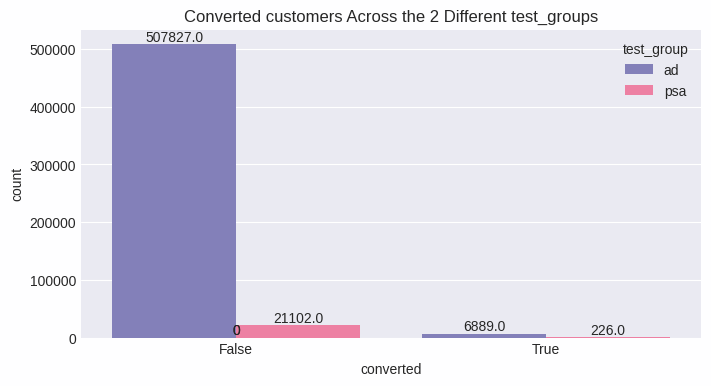

In [ ]:
plt.figure(figsize=(8, 4), dpi=100)
sns.countplot(data=df, x='converted', hue='test_group')
plt.title('Converted customers Across the 2 Different test_groups')
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.show()

## Analysis

*   Most customers in this dataset have seen advertisements.
*   There are a lot more customers who bought the product after seeing ads than those who did not see the ads.

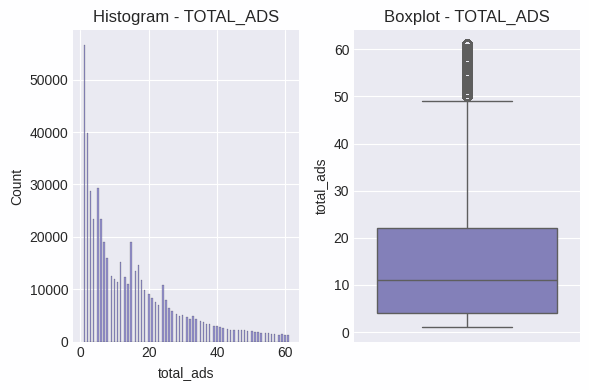

In [ ]:
variable = 'total_ads'
plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)
sns.histplot(x = variable, data  = df)
plt.title(f'Histogram - {variable.upper()}')

plt.subplot(1, 2, 2)
sns.boxplot(y = variable, data  = df)
plt.title(f'Boxplot - {variable.upper()}')
plt.tight_layout()
plt.show()

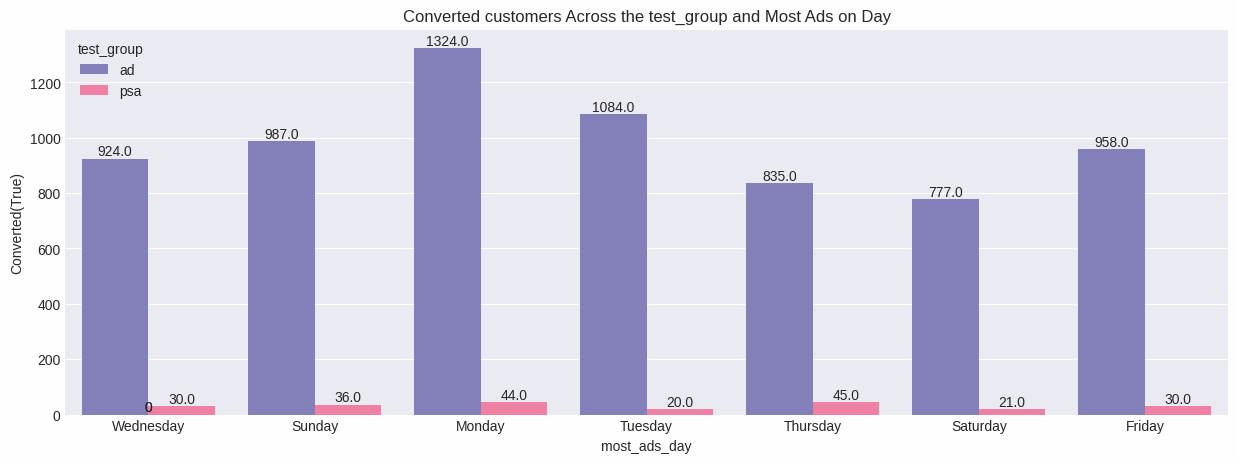

In [ ]:
# Create a count plot for 'test_group', 'most_ads_day', and 'converted' values
plt.figure(figsize=(15, 5), dpi=100)
sns.countplot(data=df[df['converted'] == True], x='most_ads_day', hue='test_group')

plt.title('Converted customers Across the test_group and Most Ads on Day')
plt.xlabel('most_ads_day')
plt.ylabel('Converted(True)')
plt.legend(title='test_group', loc='upper left')

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.show()

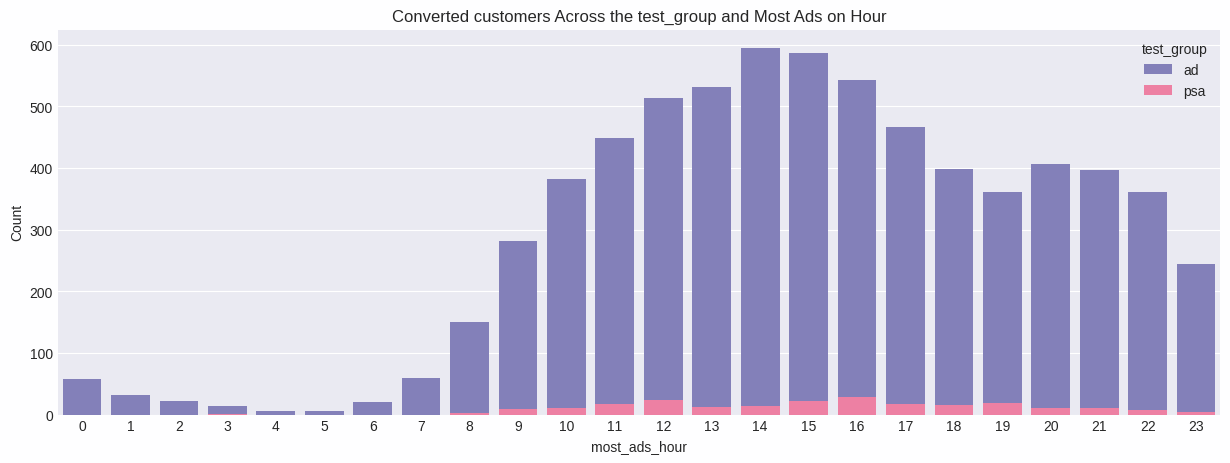

In [ ]:
plt.figure(figsize=(15, 5), dpi=100)
sns.countplot(x='most_ads_hour', hue='test_group', data=df[df['converted'] == True], dodge=False)
plt.title('Converted customers Across the test_group and Most Ads on Hour')
plt.xlabel('most_ads_hour')
plt.ylabel('Count')
plt.legend(title='test_group')
plt.savefig('plots/per_hour.png')
plt.show()

## Analysis



*   Highest Number of customer purchases are on Monday followed by Tuesday.

*   The  best time frame to display ads for optimal conversion is between 11:00 AM - 09:00 PM, with highest conversion between 01: 00 PM - 03:00 PM.


# Statistical Analysis and Hypothesis Testing


Following Questions are needed to be answerd:

1.   What is the conversion rate for the experimental group (ad) versus the
control group (PSA)?


2.   Is there a statistically significant difference in conversion rates between the two test groups(ad and psa)? What is the confidence interval for the difference in conversion rates between the two groups (ads and psa)?


3.   Does the number of ads seen by a person correlate with a higher likelihood of conversion?


4.   Is there an optimal number of ads that maximizes conversion rates?


5.   which day of the week is ad exposure most effective in driving conversions? Is there a significant difference in conversion rates based on the day of the week users were most exposed to ads?


6.   At what hour of the day ad exposure is most effective in driving conversion? Is there a significant difference in conversion rates based on the hour of the day users were most exposed to ads?


7.   How much of the observed conversions can be directly attributed to ad exposure? What is the incremental lift in conversions due to the ad campaign compared to the PSA?



---

## 1.   What is the conversion rate for the experimental group (ad) versus the control group (PSA)?


---



In [ ]:
# filter ad and psa groups
data_psa = df[df['test_group']=='psa']
data_ad = df[df['test_group']=='ad']

# Calculate and print conversion rate for each test_group
print('---------------------- Conversion Rate for '"psa"' and '"ad"' groups ----------------------')
print(f"Conversion Rate in the ad group: {data_ad['converted'].mean()*100:.2f}%")
print(f"Conversion Rate in the psa group: {data_psa['converted'].mean()*100:.2f}%")
print('-----------------------------------------------------------------------------------')

---------------------- Conversion Rate for psa and ad groups ----------------------
Conversion Rate in the ad group: 1.34%
Conversion Rate in the psa group: 1.06%
-----------------------------------------------------------------------------------


####Analysis
Conversion rate for the ad group is 1.34%, and 1.06% for psa group.


---

##2.   Is there a statistically significant difference in conversion rates between the two test groups(ad and psa)? What is the confidence interval for the difference in conversion rates between the two groups (ads and psa)?

---


###**Is there a statistically significant difference in conversion rates between the two test groups(ad and psa)?**


---





To answer This question we need to conduct hypothesis testing.


A statistical technique to ascertain whether there is a significant difference between the proportions of two independent groups is the **two-proportion z-test**. When comparing the success rates, conversion rates, or other binary outcomes between two groups, this test is frequently used.

Other tests that can be used for this scenario:



*   Chi-Square Test of Independence: Compares proportions in a contingency table, useful for larger sample sizes.

*   Fisher's Exact Test: Similar to the Chi-Square Test but used for small sample sizes.

*   McNemar's Test: Used for paired nominal data, comparing proportions before and after treatment.


#### Two-proportion z-test
Null Hypothesis (H0): There is no statistically significant difference in conversion rates between the ad and psa groups.

Alternative Hypothesis (H1): There is a statistically significant difference in conversion rates between the ad and psa groups.

In [ ]:
# Calculating the number of conversions and total customers in each group

ad_converted = df[df['test_group'] == 'ad']['converted'].sum()
ad_total = df[df['test_group']== 'ad'].shape[0]

psa_converted = df[df['test_group'] == 'psa']['converted'].sum()
psa_total = df[df['test_group'] == 'psa'].shape[0]

#performing the z-test
count = np.array([ad_converted, psa_converted])
nobs = np.array([ad_total, psa_total])
stat, p_value = proportions_ztest(count, nobs)

# Interpret the p-value
alpha = 0.05  # Significance level

# Print the results
print('---------------------- Test Results ----------------------')
print(f"z-statistic: {stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < alpha:
    print("We reject the null hypothesis, there is a statistically significant difference in conversion rates between the ad and psa groups.")
else:
    print("We failed  to reject the null hypothesis, there is no statistically significant difference in conversion rates between the ad and psa groups.")

print('-----------------------------------------------------------')

---------------------- Test Results ----------------------
z-statistic: 3.4859
p-value: 0.0005
We reject the null hypothesis, there is a statistically significant difference in conversion rates between the ad and psa groups.
-----------------------------------------------------------


#### Chi-Square Test of Independence
Null Hypothesis (H0): There is no statistically significant difference in conversion rates between the ad and psa groups.

Alternative Hypothesis (H1): There is a statistically significant difference in conversion rates between the ad and psa groups.

In [ ]:
contigency_tab = pd.crosstab(df['test_group'], df['converted'])

# instantiate chi2 test
chi2, p, _, _ = chi2_contingency(contigency_tab)


print('---------------------- Test Results ----------------------')
print(f"chi-statistic: {chi2:.4f}")
print(f"p-value: {p:.4f}")
if p < alpha:
    print("We reject the null hypothesis, there is a statistically significant difference in conversion rates between the ad and psa groups.")
else:
    print("We failed  to reject the null hypothesis, there is no statistically significant difference in conversion rates between the ad and psa groups.")

print('-----------------------------------------------------------')

---------------------- Test Results ----------------------
chi-statistic: 11.9396
p-value: 0.0005
We reject the null hypothesis, there is a statistically significant difference in conversion rates between the ad and psa groups.
-----------------------------------------------------------


###**What is the confidence interval for the difference in conversion rates between the two groups (ads and psa)?**


---

By answering this question we will check and reafirm our hypothesis test from previous question.



In [ ]:
# Calculate the conversion rates and counts for each group

ads_df = df[df['test_group'] == 'ad']
ads_conv_rate = ads_df['converted'].mean()
psa_df = df[df['test_group'] == 'psa']
psa_conv_rate = psa_df['converted'].mean()

ads_conversions = df[df['test_group'] == 'ad']['converted'].sum()
ads_total = df[df['test_group']== 'ad'].shape[0]

psa_conversions = df[df['test_group'] == 'psa']['converted'].sum()
psa_total = df[df['test_group'] == 'psa'].shape[0]
# Perform the two-proportion z-test
count = np.array([ads_conversions, psa_conversions])
nobs = np.array([ads_total, psa_total])

stat, pval = proportions_ztest(count, nobs)
(lower, upper) = proportion_confint(count, nobs, alpha=0.05)

# Print the results

print('---------------------- Test Results ----------------------')
print(f"Ads conversion rate: {ads_conv_rate:.2%}")
print(f"PSA conversion rate: {psa_conv_rate:.2%}")
print(f"Difference in conversion rates: {ads_conv_rate - psa_conv_rate:.2%}")
print(f"95% confidence interval for the difference in conversion rates: [{lower[0] - upper[1]:.2%}, {upper[0] - lower[1]:.2%}]")
print(f"p-value: {pval:.4f}")

if pval < 0.05:
    print("The difference in conversion rates for both groups (ad, psa) is statistically significant.")
else:
    print("The difference in conversion rates for both groups (ad, psa) is not statistically significant.")

print('-----------------------------------------------------------')


---------------------- Test Results ----------------------
Ads conversion rate: 1.34%
PSA conversion rate: 1.06%
Difference in conversion rates: 0.28%
95% confidence interval for the difference in conversion rates: [0.11%, 0.45%]
p-value: 0.0005
The difference in conversion rates for both groups (ad, psa) is statistically significant.
-----------------------------------------------------------


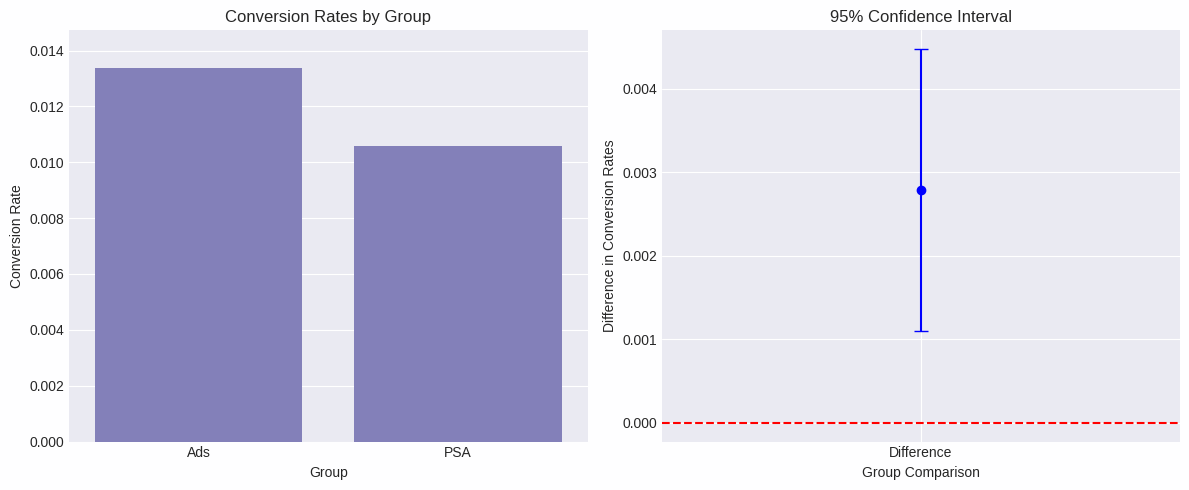

In [ ]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # Create a figure with 2 subplots

# Bar plot for Conversion Rates
sns.barplot(ax=ax1, x=['Ads', 'PSA'], y=[ads_conv_rate, psa_conv_rate])
ax1.set_title('Conversion Rates by Group')
ax1.set_ylabel('Conversion Rate')
ax1.set_xlabel('Group')
ax1.set_ylim(0, max(ads_conv_rate, psa_conv_rate) * 1.1)


diff = ads_conv_rate - psa_conv_rate
ci_lower = lower[0] - upper[1]
ci_upper = upper[0] - lower[1]

# Error bar plot for Confidence Interval
ax2.errorbar(x=['Difference'], y=[diff], yerr=[[diff - ci_lower], [ci_upper - diff]], fmt='o', capsize=5, color='blue')
ax2.axhline(0, color='red', linestyle='--')
ax2.set_title('95% Confidence Interval')
ax2.set_ylabel('Difference in Conversion Rates')
ax2.set_xlabel('Group Comparison')  # Adjusted label

plt.tight_layout()
plt.show()


###Analysis

*    Both z-test and chi-square test show that there is a statistically significant difference between the ad and psa groups.
*    The confidence interval obtained confirms our hypothesis test as shown by above plot (95% Confindence Interval) that there is a statistically significant difference between the ad and psa groups.



---


##3.   Does the number of ads seen by a person correlate with a higher likelihood of conversion?


---

We can perform correlation analysis using pearson correlation or perform hypothesis tests.

We will do both.

There is a caveat in performing hypothesis tests for numerical features As ads seen (total_ads) is a numerical feature and we need to compare it against a binary feature, which is why we first need to test for assumptions for normality and Homogeneity of variances in "total_ads" column.

Different Scenarios to consider for numerical feature:

*   Violation of Normality Only: If the data is not normally distributed but the variances are equal, then we can either normalize the data and use "Welch's t-test" which is robust to unequal variances but assumes normality, or use "Mann-Whitney U test" which is a non parametric test.

*   Violation of Homogeneity of Variances Only: if the data is normally distributed but variances are not equal, use "Welch's t-test".

*   Violation of normality and Homogeneity of variances: When bothe assumptions are violated then non-parametric tests like "Mann-Whitney U test" are generally more appropriate.

### Pearson Correlation

Null Hypothesis (H0): There is no correlation or linear relationship between ads seen by a person and the likelihood of conversion.

Alternative Hypothesis (H1): There is correlation or linear relationship between ads seen by a person and the likelihood of conversion.

In [ ]:
# Calculate the Pearson correlation coefficient and the p-value
pearson_corr, p_value = pearsonr(df['total_ads'], df['converted'])


# Calculate the test statistic manually "Fisher's z-transformation"
n = len(df)
t_stat = pearson_corr * np.sqrt((n - 2) / (1 - pearson_corr**2))


# Compare with critical value or p-value
alpha = 0.05
degrees_of_freedom = n - 2
critical_value = t.ppf(1 - alpha/2, degrees_of_freedom)

# Print the results
print('---------------------- Test Results ----------------------')
# print pearson correlation coefficient and p_value
print(f"Pearson Correlation Coefficient: {pearson_corr:.4f}")
print(f"p-value: {p_value:.4f}")


print(f"Test statistic: {t_stat:.4f}")
print(f"Critical value: {critical_value:.4f}")

# Decision based on p-value

if p_value < alpha and critical_value < t_stat:
    print("We reject the null hypothesis, There is correlation between ads seen by a person and the likelihood of conversion.")
else:
    print("We failed  to reject the null hypothesis, There is no correlation between ads seen by a person and the likelihood of conversion.")

print('-----------------------------------------------------------')

---------------------- Test Results ----------------------
Pearson Correlation Coefficient: 0.1480
p-value: 0.0000
Test statistic: 109.5691
Critical value: 1.9600
We reject the null hypothesis, There is correlation between ads seen by a person and the likelihood of conversion.
-----------------------------------------------------------


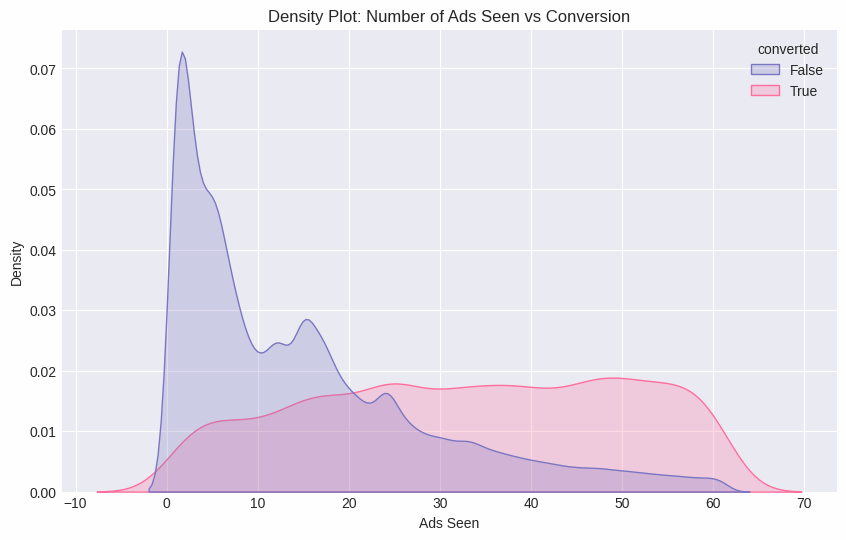

In [ ]:
#copy original dataset
df_kde = df.copy()
#convert column to category for  better plotting
df_kde['converted'] = df_kde['converted'].astype('category')

# Create the KDE plot
plt.figure(figsize=(10, 6))

# Plot conditional densities for each binary category
sns.kdeplot(data=df_kde, x='total_ads', hue='converted', common_norm=False, fill=True)

# Labels and title
plt.xlabel('Ads Seen')
plt.ylabel('Density')
plt.title('Density Plot: Number of Ads Seen vs Conversion')
plt.savefig('plots/density_seen.png')
plt.show()

### Checking Violation of normality and Homogeneity of variances of the Numerical feature (total_ads)



*   Normality Check: Tests like "Shapiro-Wilk Test", "Kolmogorov-Smirnov Test", and "Anderson-Darling Test" can be used or we can do a visual check suing "Q-Q Plot".

*   Homogeneity of variances Check: Tests like "Levene's Test", "Bartlett's Test", and "Fligner-Killeen Test" or visual check using "Boxplot".


####Normality Check

Null Hypothesis (H0): The 'total_ads' is normally distributed.

Alternative Hypothesis (H1):The 'total_ads' is not normally distributed.

In [ ]:
data = df['total_ads']

# Perform the Kolmogorov-Smirnov test
stat, p_value = kstest(data, 'norm')

print('---------------------- Test Results ----------------------')
print(f"Kolmogorov-Smirnov statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")

# check the significance level
if p_value < alpha:
    print("We reject the null hypothesis, the feature 'total_ads' is not normally distributed.")
else:
    print("We failed  to reject the null hypothesis, and 'total_ads' is normally distributed.")

print('-----------------------------------------------------------')

---------------------- Test Results ----------------------
Kolmogorov-Smirnov statistic: 0.8717
P-value: 0.0000
We reject the null hypothesis, the feature 'total_ads' is not normally distributed.
-----------------------------------------------------------


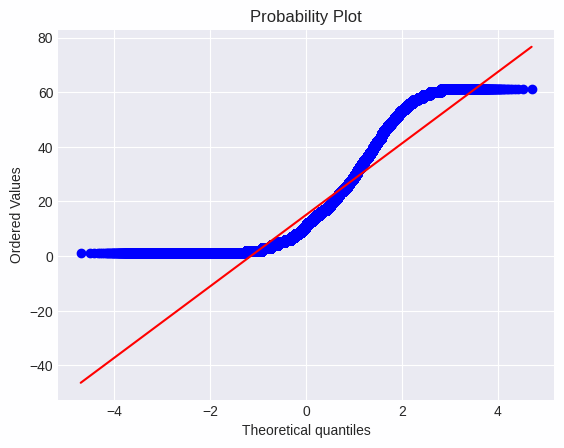

In [ ]:
# Generate Q-Q plot
stats.probplot(data, dist="norm", plot=plt)
plt.show()

####Homogeneity of variances

Null Hypothesis (H0): The variances of the feature 'total_ads' across the two target classes "converted (True, False)" is homogeneous.

Alternative Hypothesis (H1): The variances of the feature 'total_ads' across the two target classes "converted (True, False)" is not homogeneous.

In [ ]:
# Sample data
group1 = df[df['converted']== True]['total_ads']
group2 = df[df['converted']== False]['total_ads']

# Perform Bartlett's test
stat, p_value = bartlett(group1, group2)

print('---------------------- Test Results ----------------------')
print(f"Bartlett's test statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")

# check the significance level
if p_value < alpha:
    print("We reject the null hypothesis, The variances of the feature 'total_ads' across "'converted (True, False)'" is homogeneous.")
else:
    print("We failed  to reject the null hypothesis, The variances of the feature 'total_ads' across "'converted (True, False)'" is not homogeneous.")
print('-----------------------------------------------------------')


---------------------- Test Results ----------------------
Bartlett's test statistic: 683.7454
P-value: 0.0000
We reject the null hypothesis, The variances of the feature 'total_ads' across converted (True, False) is homogeneous.
-----------------------------------------------------------


####Analysis

Since both Normality, Homogeneity of variances checks have failed, meaning 'total_ads' column in not normally distributed as shown by normality check using Kolmogorov-Smirnov Test and Q-Q plot, and also variances across different sample are not equal as shown by  Bartlett's test.

We will use Mann-Whitney U test to check if ads seen by a person have an impact on the likelihood of conversion.

###Mann-Whitney U test

Null Hypothesis (H0): There is no relation in the number of ads seen and the likelihood of conversion.

Alternative Hypothesis (H1): There is a relation in the number of ads seen and the likelihood of conversion.

In [ ]:
# Sample data
group1 = df[df['converted']== True]['total_ads']
group2 = df[df['converted']== False]['total_ads']


print('---------------------- Test Results ----------------------')
# Perform the Mann-Whitney U test
stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')

print(f"Mann-Whitney U statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")

# check the significance level
if p_value < alpha:
    print("We reject the null hypothesis, There is a relation in the number of ads seen and the likelihood of conversion.")
else:
    print("We failed  to reject the null hypothesis, There is no relation in the number of ads seen and the likelihood of conversion.")
print('-----------------------------------------------------------')

---------------------- Test Results ----------------------
Mann-Whitney U statistic: 2993998088.5000
P-value: 0.0000
We reject the null hypothesis, There is a relation in the number of ads seen and the likelihood of conversion.
-----------------------------------------------------------


###Analysis

Both Pearson correlation and Mann-Whitney U test have shown that customers who see more ads will most likely convert or make a purchase.



---


##4.   Is there an optimal number of ads that maximizes conversion rates?


---



Optimal number of ads seen: 61.0
Highest conversion rate: 10.85%


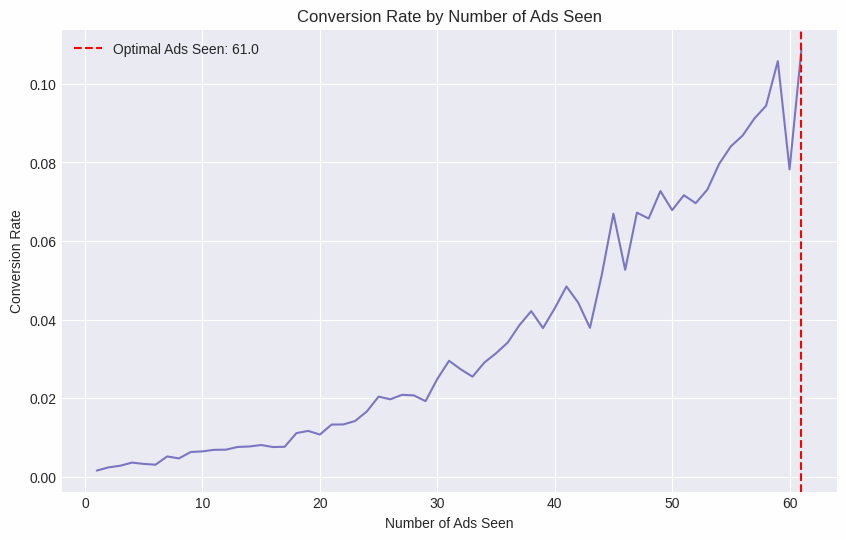

In [ ]:
# filter ad group
df_conversion = df[df['test_group'] == 'ad']

#remove values outside a certain limit
df_conversion = df_conversion[df_conversion['total_ads'] < 500]

# group total_ads on converted and calculate the conversion rate for each group
df_conversion = df_conversion[['total_ads', 'converted']]
df_conversion['converted'] = df_conversion['converted'].astype(int)
conversion_rates = df_conversion.groupby('total_ads')['converted'].mean().reset_index()

# Find the optimal number of ads (max conversion rate)
optimal_ads_seen = conversion_rates.loc[conversion_rates['converted'].idxmax()]

print(f"Optimal number of ads seen: {optimal_ads_seen['total_ads']}")
print(f"Highest conversion rate: {optimal_ads_seen['converted']:.2%}")

# Visualize the conversion rates
plt.figure(figsize=(10, 6))
sns.lineplot(x='total_ads', y='converted', data=conversion_rates)
plt.title('Conversion Rate by Number of Ads Seen')
plt.xlabel('Number of Ads Seen')
plt.ylabel('Conversion Rate')
plt.axvline(optimal_ads_seen['total_ads'], color='r', linestyle='--', label=f'Optimal Ads Seen: {optimal_ads_seen["total_ads"]}')
plt.legend(loc = 2)
plt.show()

####Analysis

Optimal number of ads that can maximize conversion rates is 61.



---

##5.   which day of the week is ad exposure most effective in driving conversions? Is there a significant difference in conversion rates based on the day of the week users were most exposed to ads?


---




**which day of the week is ad exposure most effective in driving conversions?**


---



In [ ]:
#filter ad group
df_ad = df[df['test_group'] == 'ad']
df_ad['converted'] = df_ad['converted'].astype(int)

Most effective day: Monday
Highest conversion rate: 1.74%


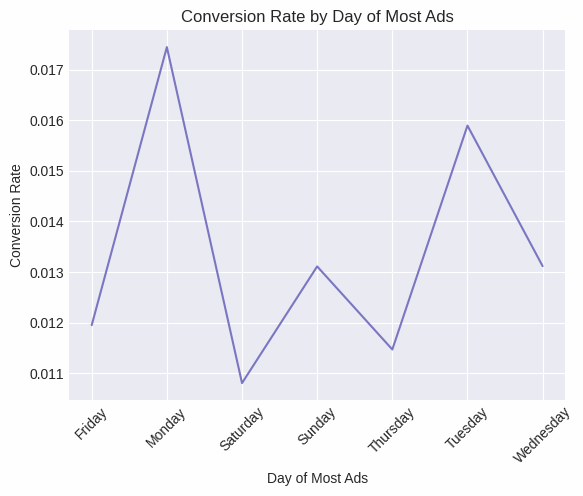

In [ ]:
#which day of the week is ad exposure most effective in driving conversions?

#find conversion rate for day of the week
df_ad_convert_day = df_ad.groupby('most_ads_day')['converted'].mean().reset_index()
most_effective_day = df_ad_convert_day.loc[df_ad_convert_day['converted'].idxmax()]

print(f"Most effective day: {most_effective_day['most_ads_day']}")
print(f"Highest conversion rate: {most_effective_day['converted']:.2%}")

# Visualize conversion rates by day
sns.lineplot(x='most_ads_day', y='converted', data=df_ad_convert_day)
plt.xlabel('Day of Most Ads')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Day of Most Ads')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if many days
plt.show()



**Is there a significant difference in conversion rates based on the day of the week users were most exposed to ads?**


---



To answer this question we will perform a hypothesis test.


Null hypothesis (H0): There is no significant difference in conversion rates based on the day of the week users were most exposed to ads


Alternative Hypothesis (H1): There is a significant difference in conversion rates based on the day of the week users were most exposed to ads.



In [ ]:
# Group data by 'most_ads_day' and get 'converted' values as lists
day_converted_lists = df_ad.groupby('most_ads_day')['converted'].apply(list)

# Perform Kruskal-Wallis H-test
h_statistic, p_value = kruskal(*day_converted_lists)  # Unpack the lists


print('---------------------- Test Results ----------------------')
print(f"Kruskal-Wallis H-statistic: {h_statistic:.4f}")
print(f"p-value: { p_value:.4f}")
if pval < alpha:
    print("We reject the null hypothesis, there is a significant difference in conversion rates based on the day of the week users were most exposed to ads.")
else:
    print("We failed  to reject the null hypothesis, there is a significant difference in conversion rates based on the day of the week users were most exposed to ads.")

print('-----------------------------------------------------------')

---------------------- Test Results ----------------------
Kruskal-Wallis H-statistic: 197.4254
p-value: 0.0000
We reject the null hypothesis, there is a significant difference in conversion rates based on the day of the week users were most exposed to ads.
-----------------------------------------------------------


####Analysis

*    Most effective day to get more customers to purchase is "Monday".
*    The day at which advertisements are place is also of very important as shown by a hypothesis test.



---


##6.   At what hour of the day ad exposure is most effective in driving conversion? Is there a significant difference in conversion rates based on the hour of the day users were most exposed to ads?
---



**At what hour of the day ad exposure is most effective in driving conversion?**


---



In [ ]:
#filter ad group
df_ad = df[df['test_group'] == 'ad']
df_ad['converted'] = df_ad['converted'].astype(int)

Most effective hour: 16.0
Highest conversion rate: 1.63%


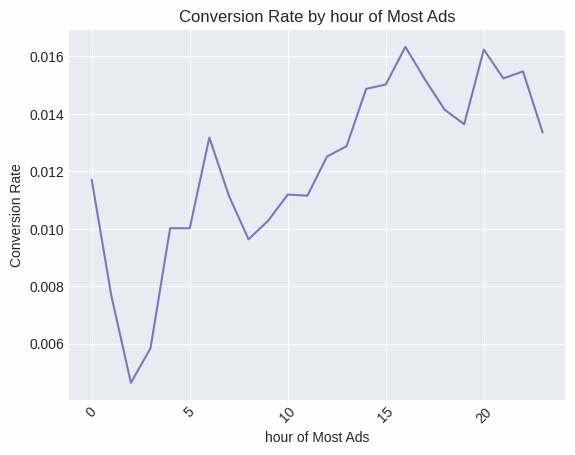

In [ ]:
#At what hour of the day ad exposure is most effective in driving conversion?
# find conversion rate for hour of the day
df_ad_convert_hour = df_ad.groupby('most_ads_hour')['converted'].mean().reset_index()
most_effective_hour = df_ad_convert_hour.loc[df_ad_convert_hour['converted'].idxmax()]

print(f"Most effective hour: {most_effective_hour['most_ads_hour']}")
print(f"Highest conversion rate: {most_effective_hour['converted']:.2%}")

# Visualize conversion rates by day
sns.lineplot(x='most_ads_hour', y='converted', data=df_ad_convert_hour)
plt.xlabel('hour of Most Ads')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by hour of Most Ads')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if many hours
plt.show()


**Is there a significant difference in conversion rates based on the hour of the day users were most exposed to ads?**


---
To answer this question we will perform hypothesis test.

Null hypothesis (H0): There is no significant difference in conversion rates based on the hour of the day users were most exposed to ads


Alternative Hypothesis (H1): There is a significant difference in conversion rates based on the hour of the day users were most exposed to ads.


In [ ]:
# Statistical test (Kruskal-Wallis H-test for non-normal data)

# Group data by 'most_ads_day' and get 'converted' values as lists
hour_converted_lists = df_ad.groupby('most_ads_hour')['converted'].apply(list)

# Perform Kruskal-Wallis H-test
h_statistic, p_value = kruskal(*hour_converted_lists)  # Unpack the lists

print('---------------------- Test Results ----------------------')
print(f"Kruskal-Wallis H-statistic: {h_statistic:.4f}")
print(f"p-value: { p_value:.4f}")

if pval < alpha:
    print("We reject the null hypothesis, there is a significant difference in conversion rates based on the hour of the day users were most exposed to ads.")
else:
    print("We failed  to reject the null hypothesis, there is a significant difference in conversion rates based on the hour of the day users were most exposed to ads.")

print('-----------------------------------------------------------')

---------------------- Test Results ----------------------
Kruskal-Wallis H-statistic: 195.3447
p-value: 0.0000
We reject the null hypothesis, there is a significant difference in conversion rates based on the hour of the day users were most exposed to ads.
-----------------------------------------------------------


###Analysis

*   Most effective hour to get more customers to purchase is 04:00 PM.
*   The hour at which ads are placed and exposed to customers is also of very importance.



---


##7.   How much of the observed conversions can be directly attributed to ad exposure? What is the incremental lift in conversions due to the ad campaign compared to the PSA?
---


**How much of the observed conversions can be directly attributed to ad exposure?**


---


We can use Attributale Risk(AR)/Absolute Risk Reduction(ARR) formula to answer this question.
Attributable Risk (AR) is calculated as:

$ \text{AR} = {\text{Risk}_{\text{Exposed}}} - {\text{Risk}_{\text{unexposed}}}$

or can be written as

$ \text{AR} = {\text{Conversion Rate}_{\text{ad}}} - {\text{Conversion Rate}_{\text{psa}}}$

In [ ]:
# Filter the data for each group
ads_df = df[df['test_group'] == 'ad']
psa_df = df[df['test_group'] == 'psa']

# Calculate conversion rates
ads_conversion_rate = ads_df['converted'].mean()
psa_conversion_rate = psa_df['converted'].mean()

# Calculate Attributable Risk (AR)
attributable_risk = ads_conversion_rate - psa_conversion_rate

# Calculate total conversions in the ad group
total_conversions_ads = ads_df['converted'].sum()

# Calculate the number of conversions attributable to the ad exposure
conversions_attributable_to_ads = attributable_risk * ads_df.shape[0]

# Calculate the percentage of conversions attributable to the ad exposure
percentage_attributable_to_ads = (conversions_attributable_to_ads / total_conversions_ads) * 100

#print the results
print('---------------------- Test Results ----------------------')
print(f"Ads conversion rate: {ads_conversion_rate:.2%}")
print(f"PSA conversion rate: {psa_conversion_rate:.2%}")
print(f"Attributable Risk (AR): {attributable_risk:.2%}")
print(f"Total conversions in ad group: {total_conversions_ads}")
print(f"Conversions attributable to ad exposure: {conversions_attributable_to_ads:.0f}")
print(f"Percentage of conversions attributable to ad exposure: {percentage_attributable_to_ads:.2f}%")
print('-----------------------------------------------------------')

---------------------- Test Results ----------------------
Ads conversion rate: 1.34%
PSA conversion rate: 1.06%
Attributable Risk (AR): 0.28%
Total conversions in ad group: 6889
Conversions attributable to ad exposure: 1435
Percentage of conversions attributable to ad exposure: 20.83%
-----------------------------------------------------------


**What is the incremental lift in conversions due to the ad campaign compared to the PSA?**


---


We can use the "Relative Risk Increase (RRI)/Incremental Conversion Lift" formula to anwer this question.
Incremental Conversion Lift is calculated as:

$ \text{Incremental Lift} = \left( \frac{\text{AR}}{\text{Conversion Rate}_{\text{psa}}} \right) \times 100 $

Where ARR is:

$ \text{AR} = {\text{Conversion Rate}_{\text{ad}}} - {\text{Conversion Rate}_{\text{psa}}}$

In [ ]:
# Calculate conversion rates
ads_conversion_rate = ads_df['converted'].mean()
psa_conversion_rate = psa_df['converted'].mean()

# Calculate Absolute Risk Reduction (ARR)
arr = ads_conversion_rate - psa_conversion_rate

# Calculate Incremental Lift
incremental_lift = (arr / psa_conversion_rate) * 100

#print the results
print('---------------------- Test Results ----------------------')

print(f"Ads conversion rate: {ads_conversion_rate:.2%}")
print(f"PSA conversion rate: {psa_conversion_rate:.2%}")
print(f"Absolute Risk Reduction (ARR): {arr:.2%}")
print(f"Incremental Lift: {incremental_lift:.2f}%")

print('-----------------------------------------------------------')

---------------------- Test Results ----------------------
Ads conversion rate: 1.34%
PSA conversion rate: 1.06%
Absolute Risk Reduction (ARR): 0.28%
Incremental Lift: 26.31%
-----------------------------------------------------------


*    20.83% of the customers who made a purchase can be directly attributed to the ad exposure.
*    26.31% of the customers made a purchase due to the ad campaign when compared against psa.


####Analysis

Directly attributing conversions or incremental lift in conversions solely to ad exposure involves several challenges and considerations:

#### Challenges in Attribution
1. **Selection Bias**: Users who see the ad might already be more predisposed to purchase, leading to overestimation of the ad's impact.
2. **Multiple Touchpoints**: Users might encounter various marketing efforts (organic search, social media) before converting, making it difficult to isolate the ad's specific influence.
3. **Attribution Models**: Different models allocate credit for a conversion across various touchpoints, influencing the perceived impact of ads.

#### Approaches for Attribution Analysis

1. **Uplift Modeling**:
   - Requires a control group with similar characteristics who didn't see the ad.
   - Compare conversion rates between the ad group and the control group to estimate incremental lift.

2. **Difference-in-Differences (DID)**:
   - Use historical data on conversion rates before and after the ad campaign for both groups.
   - Assumptions:
     - Trends in conversion rates for both groups would have been similar without the ad campaign.
     - No other significant events influenced conversion rates.
   - Calculation: DID = Treatment Group Difference - Control Group Difference

   where
    - Treatment Group Difference = Treatment_Post - Treatment_Pre
    - Control Group Difference = Control_Post - Control_Pre

   - Positive lift suggests the ad campaign increased conversions compared to the PSA group.

3. **Observational Techniques**:
   - **Matching Techniques**: Match users in the ad group with similar users in the PSA group based on characteristics and analyze the difference in conversion rates. Selection bias might still be an issue.
   - **Interrupted Time Series Analysis**: Analyze historical conversion rate data for both groups before, during, and after the ad campaign. Look for a sudden change in the ad group's conversion rate coinciding with the campaign launch. External factors might influence the observed changes.

4. **Lift Charts**:
   - Visualize the conversion rate over time for both groups. Look for a significant increase in the ad group's conversion rate after ad exposure. External factors might influence the observed changes.

5. **Contribution Analysis (Multi-Touch Attribution Model)**:
   - Use a multi-touch attribution model (e.g., U-shaped, W-shaped) to consider various touchpoints users encounter before conversion. Provides insights into the percentage of credit assigned to the ad exposure within the model. However, it's not a definitive measure of direct attribution.

#### Interpretation and Limitations

- **Uplift Modeling**: Provides the most reliable estimate, but ethical considerations for the control group are crucial.
- **DID and Observational Techniques**: Offer alternatives but have limitations due to potential confounding factors.
- **Lift Charts and Contribution Analysis**: Useful for visualizing impact but should be interpreted cautiously.

#### Additional Considerations

- Monitor other user behavior metrics (clicks, website visits) alongside conversions to understand the ad campaign's influence on user engagement.
- Track changes in user behavior after ad exposure (e.g., increased website visits, product page views) to gauge potential ad influence.

By employing these methods and recognizing their limitations, we can gain valuable insights into the potential incremental lift in conversions attributable to our ad campaign compared to the PSA approach.

#### Key Takeaways

- Focus on understanding the overall impact of the ad campaign on conversions, considering the limitations.
- Use a combination of methods to estimate the incremental lift in conversions and interpret the results as an estimate, not a definitive measure of the ad campaign's direct impact.


# Conclusions and Recommendations

## Conclusions

Based on the analysis conducted in this notebook, we can draw the following conclusions:

 - The ad campaign has a positive impact on conversion rates compared to the PSA group.

 - The optimal number of ads seen to maximize conversion rates is around 61.

 - Monday is the most effective day for ad exposure in driving conversions.

 - 4:00 PM is the most effective hour for ad exposure in driving conversions.

 - There is a significant difference in conversion rates based on the day and hour of the week users were most exposed to ads.

 - While it's challenging to directly attribute conversions solely to ad exposure, the analysis suggests a significant incremental lift in conversions due to the ad campaign.

## Recommendations

Based on the findings, we recommend the following actions:

 - Optimize ad frequency: Focus on delivering around 61 ads to users to maximize conversion rates.

 - Prioritize ad delivery on Mondays: Allocate a larger portion of the ad budget to Monday to capitalize on the higher conversion rates observed on this day.

 - Target ad delivery around 4:00 PM: Schedule ad campaigns to reach users around 4:00 PM when they are more likely to convert.

 - Continue monitoring and refining ad campaigns: Regularly analyze conversion data and adjust ad targeting, creative, and delivery strategies to further improve performance.

 - Explore advanced attribution models: Consider implementing multi-touch attribution models to gain a more comprehensive understanding of the impact of ad exposure within the broader marketing mix.

 - Invest in user segmentation: Leverage data to create personalized ad experiences for different user segments to improve engagement and conversion rates.

By implementing these recommendations, We can further optimize its ad campaigns and maximize the return on investment.
